## MNIST Dataset with Deep Learning Techniques

### MNIST MLP with Dropout

#### Import Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
''' 3. MNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.MNIST(root = "./data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "./data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [6]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


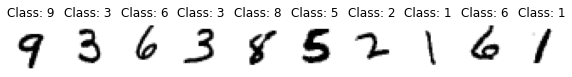

In [7]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
''' 6. Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5 # 몇 퍼센트의 노드에 대해 가중치를 계산하지 않을 것인지 명시

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        # 시그모이드 함수의 결괏값에 대해 Dropout을 적용, x 값에 적용하며 p 값은 몇 퍼센트의 노드에 대해 계산하지 않을 것인지 조정
        # training 옵션을 통해 학습 상태일 때와 검증 상태일 때, Dropout을 다르게 적용 → 학습 과정 속에서는 랜덤으로 노드를 선택해 가중치 업데이트 X
        # 평가 과정 속에서는 모든 노드를 이용해 Output을 계산 → modle.train()을 명시할 때 True, model.eval()으로 명시할 때 False
        # 이론상 일반화 성능이 높아지는 것은 학습 데이터셋과 검증 데이터셋의 피처 및 레이블의 분포 간 많은 차이가 있을 때 발생
        # 많은 차이가 없을 경우 성능이 떨어질 수도 있고, 이 경우 Epoch 수를 늘려주는 것이 효과적이며 보통 ReLU()와 잘 어울림
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [11]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
''' 10. MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

c:\Users\lucky\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.720936
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.767642
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.701451
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.337036
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.621025
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.390235
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.660209
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.365473
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.358118
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.703325

[EPOCH: 1], 	Test Loss: 0.4202, 	Test Accuracy: 87.40 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.423455
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.224402
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.494899
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.584355
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.561509
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.732986
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.397021
T

### MNIST MLP With Dropout RELU

In [17]:
''' 6. Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x
        # F.sigmoid() 를 F.relu()로 바꿔주기만 하면 됨

In [18]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.320282
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.099095
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 1.282736
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.817711
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.777772
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.334972
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.313171
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.703080
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.516463
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.740639

[EPOCH: 1], 	Test Loss: 0.3248, 	Test Accuracy: 90.81 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.427911
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.412913
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.379662
Train Epoch: 2 [19200/60000 (32%)

### MNIST MLP with Dropout ReLU BN

In [20]:
# Batch Normalization은 다양한 차원에 따라 적용되는 함수명이 다름
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        # MLP 내의 각 Layer에서 데이터는 1-Dimension 크기의 벡터 값을 계산하기 때문에 nn.BatchNorm1d 를 사용
        # Activation 함수 적용 이전과 이후 시점에 대한 여부는 연구자마다 의견이 다름
        self.batch_norm1 = nn.BatchNorm1d(512) # 첫 번째 FCL의 Output이 512 크기의 벡터값이기 때문에 512차원으로 설정
        self.batch_norm2 = nn.BatchNorm1d(256) # 두 번째 FCL의 Output이 256 크기의 벡터이기 떄문에 256 차원으로 설정

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x) # 첫 번째 FCL의 Output을 위에서 정의한 'self.batch_norm1'의 Input으로 이용
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x) # 위와 동일
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [21]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.494573
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.537417
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.524715
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.214445
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.239259
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.254848
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.121371
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.326364
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.286771
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.263716

[EPOCH: 1], 	Test Loss: 0.1552, 	Test Accuracy: 95.27 % 


### MNIST MLP With Dropout ReLU BN He

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [12]:
import torch.nn.init as init # Weight, Bias 등 딥러닝 모델에서 초깃값으로 설정되는 요소에 대한 모듈 
def weight_init(m): # MLP 모델 내의 Weight를 초기화할 부분을 설정하기 위해 함수 정의
    if isinstance(m, nn.Linear): # MLP 모델을 구성하고 있는 파라미터 중 nn.Linear에 해당하는 파라미터 값에 대해서만 지정
        init.kaiming_uniform_(m.weight.data) # nn.Linear에 해당하는 파라미터 값에 대해 he_initialization을 이용해 파라미터 값 초기화

model = Net().to(DEVICE)
model.apply(weight_init) # 위에서 정의한 함수를 Net() 클래스의 인스턴스인 model에 적용
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [13]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.590274
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.717140
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.565695
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.541182
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.513088
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.496360
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.438316
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.339089
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.541938
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.332615

[EPOCH: 1], 	Test Loss: 0.2205, 	Test Accuracy: 93.43 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.650676
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.166724
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.218639
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.385776
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.373290
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.133800
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.246293
T

MNIST MLP With Dropout ReLU BN He Adam

In [14]:
''' 7. Optimizer, Objective Function 설정하기 '''
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [15]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 3.347716
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.083784
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.536624
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.186708
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.489060
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.555615
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.504929
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.554814
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.280780
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.514773

[EPOCH: 1], 	Test Loss: 0.1266, 	Test Accuracy: 96.02 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.229228
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.051498
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.176703
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.126580
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.118078
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.145144
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.342205
T